In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
image_folder = 'timecourse-stainA'
negative_control = 'iPSC_PGP1_1.czi_fluorescence.csv'

neg_df = pd.read_csv(os.path.join(image_folder,negative_control), index_col=0)
neg_df

,area_pixels,integrated_intensity_channel_0,integrated_intensity_channel_1,integrated_intensity_channel_2,integrated_intensity_channel_3,integrated_intensity_channel_4
label,,,,,,
1,16731.0,147865636,36606482,7493956,33105616,6765397
2,17951.0,178004912,36714232,9435605,29747178,6203368
3,29920.0,323874723,69124204,12304850,57061061,9630166
4,33143.0,295935501,69106769,16330635,58297303,11632767
5,19914.0,217036045,44651324,8016068,36236391,5457922
...,...,...,...,...,...,...
80,32198.0,388923362,59566535,14185189,65459732,15747142
81,37672.0,382086960,71982024,13670672,76379661,16642154
82,24656.0,221608235,46351588,7699301,49070660,7308903


In [3]:
pos_df = pd.read_csv(os.path.join(image_folder,"Day15_PGP1_2_early_pachytene.czi_fluorescence.csv"), index_col=0)
pos_df

,area_pixels,integrated_intensity_channel_0,integrated_intensity_channel_1,integrated_intensity_channel_2,integrated_intensity_channel_3,integrated_intensity_channel_4
label,,,,,,
1,9738.0,261415171,263291904,52450751,27362359,39300992
2,10105.0,218997093,26319958,11609429,7151713,17250452
3,21507.0,575221960,236143119,382536364,139626621,731560515
4,30981.0,527418250,569632625,109783209,27895610,15962799
5,22979.0,385758071,65174203,15610510,41978934,10833652
...,...,...,...,...,...,...
121,14201.0,352576676,244730961,37796368,16060920,6533626
122,20030.0,527807005,53464701,36600458,17701490,98694584
123,13852.0,412408465,735983507,106286859,28093437,15222783


In [4]:
#Do linear regression to calculate background levels
def regress_background(df):
    results_df = pd.DataFrame(columns=['Channel', 'Slope', 'Intercept'])
    # Loop through each intensity column
    for col in df.columns:
        if col.startswith('integrated_intensity_'):
            # Prepare data for linear regression
            X = df['area_pixels']
            y = df[col]
            
            # Perform linear regression using numpy.polyfit
            slope, intercept = np.polyfit(X, y, 1)
            
            # Store results
            results_df = pd.concat([results_df, pd.DataFrame({'Channel': [col], 'Slope': [slope], 'Intercept': [intercept]})])

    return results_df.set_index('Channel')

#Adjust a channels based on background levels
def remove_background(df, bg_coeffs):
    results_df = df.copy()
    for col in df.columns:
        if col.startswith('integrated_intensity_'):
            results_df[col] = df[col] - np.poly1d(bg_coeffs.loc[col])(df['area_pixels'])
    return results_df

def binarize(df, thresholds):
    for column, threshold in thresholds.items():
        df[column + '_binarized'] = (df[column] > threshold).astype(int)
    
    return df

#Calculate background based on the negative control
bg_df = regress_background(neg_df)
print(bg_df)

### Define cutoffs as 5x the 95-th percentile of the background

cutoffs = 5*remove_background(neg_df, bg_df).quantile(0.95)
cutoffs

                                      Slope     Intercept
Channel                                                  
integrated_intensity_channel_0  9838.236672  2.950948e+07
integrated_intensity_channel_1  2176.235370  1.008867e+06
integrated_intensity_channel_2   427.582275  1.415477e+06
integrated_intensity_channel_3  2155.351830 -4.021989e+06
integrated_intensity_channel_4   392.701760  7.075866e+05


area_pixels                       2.158675e+05
integrated_intensity_channel_0    5.237273e+08
integrated_intensity_channel_1    5.837166e+07
integrated_intensity_channel_2    2.114418e+07
integrated_intensity_channel_3    2.858840e+07
integrated_intensity_channel_4    3.064481e+07
Name: 0.95, dtype: float64

In [5]:
def make_plot_vs_area(df, title="plot"):
    # Define colors for the plots
    colors = ['gray', 'red', 'blue', 'green', 'magenta']
    
    # Plotting
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the size as necessary
    fig.suptitle(title)
    
    # Loop through each channel to create scatter plots
    for i in range(5):  # Assuming there are 5 channels
        axs[i].scatter(df[f'area_pixels'], df[f'integrated_intensity_channel_{i}'], color=colors[i])
        axs[i].set_title(f'Channel {i}')
        axs[i].set_xlabel('Area (pixels)')
        axs[i].set_ylabel('Background-Subtracted Fluorescence Intensity')
    
    # Tight layout to ensure no overlap of subplots
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

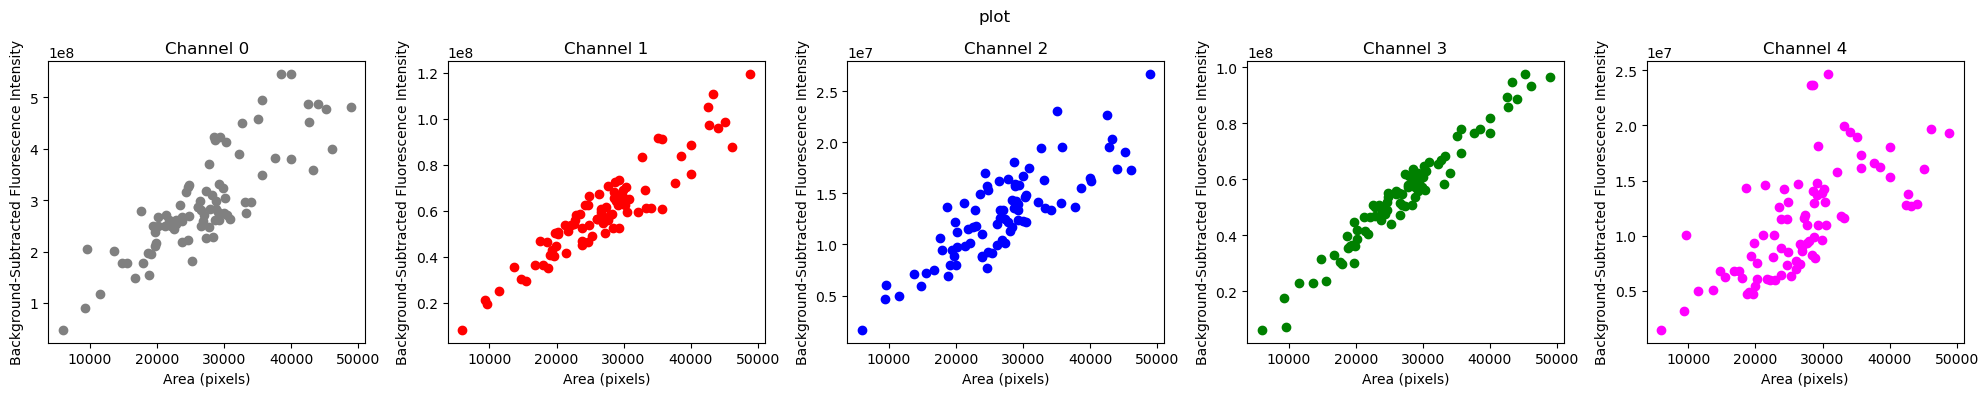

In [6]:
make_plot_vs_area(neg_df)

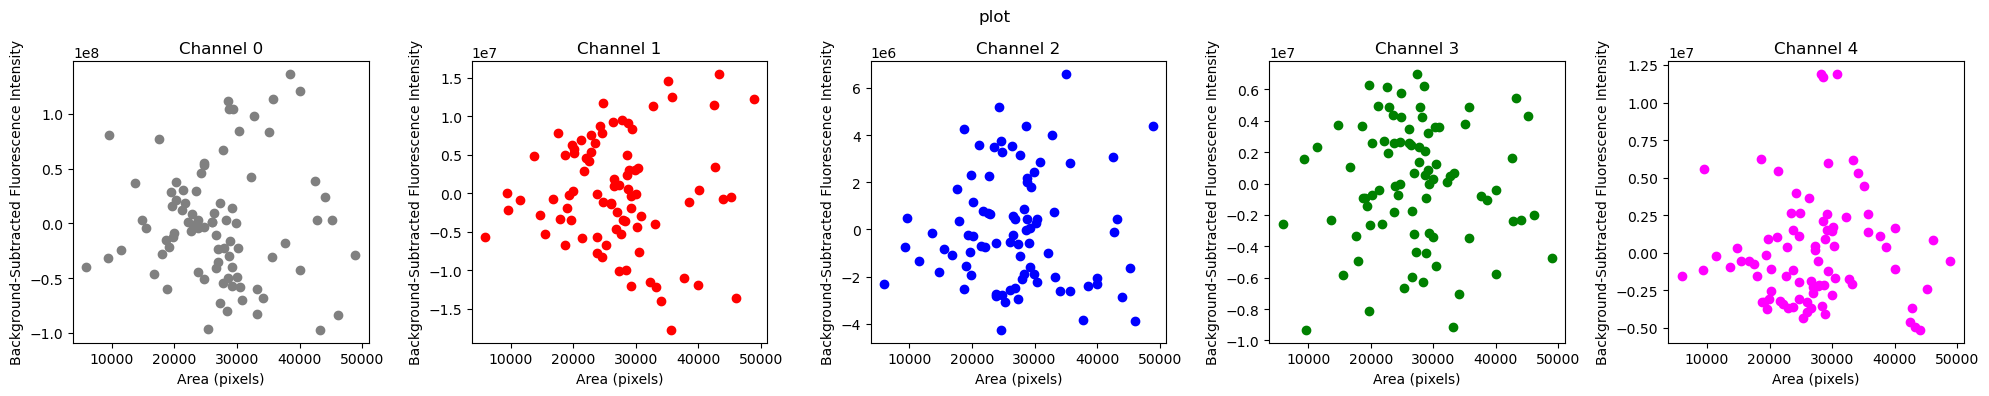

In [7]:
make_plot_vs_area(remove_background(neg_df, bg_df))

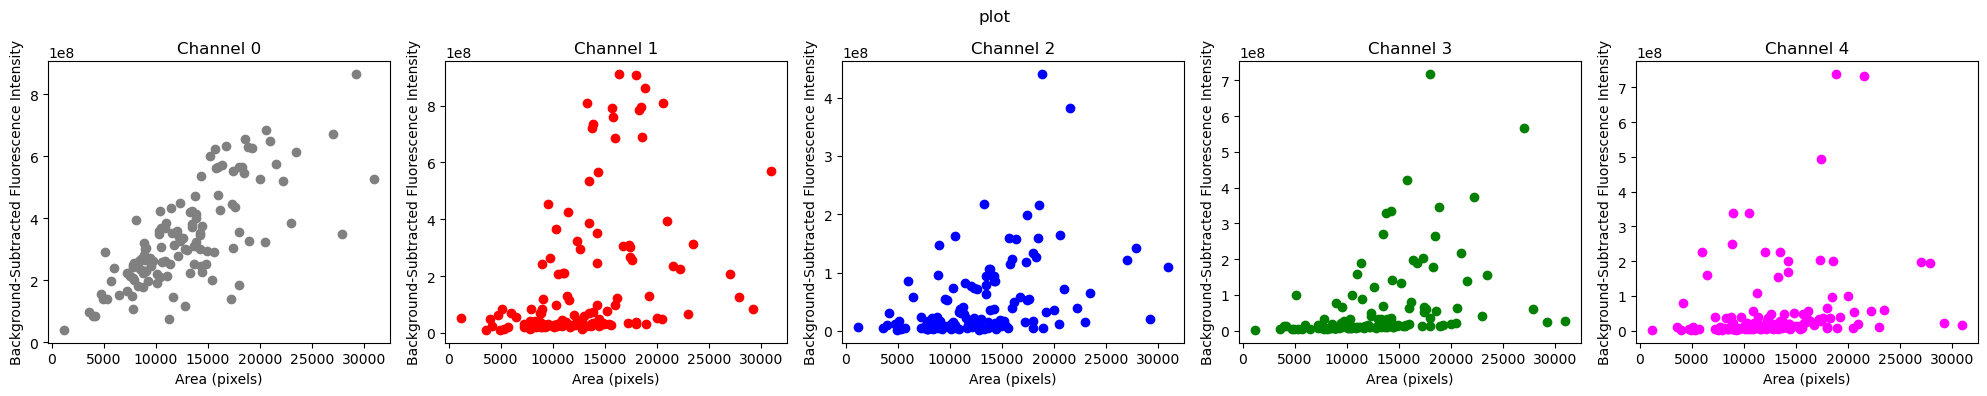

In [8]:
make_plot_vs_area(pos_df)

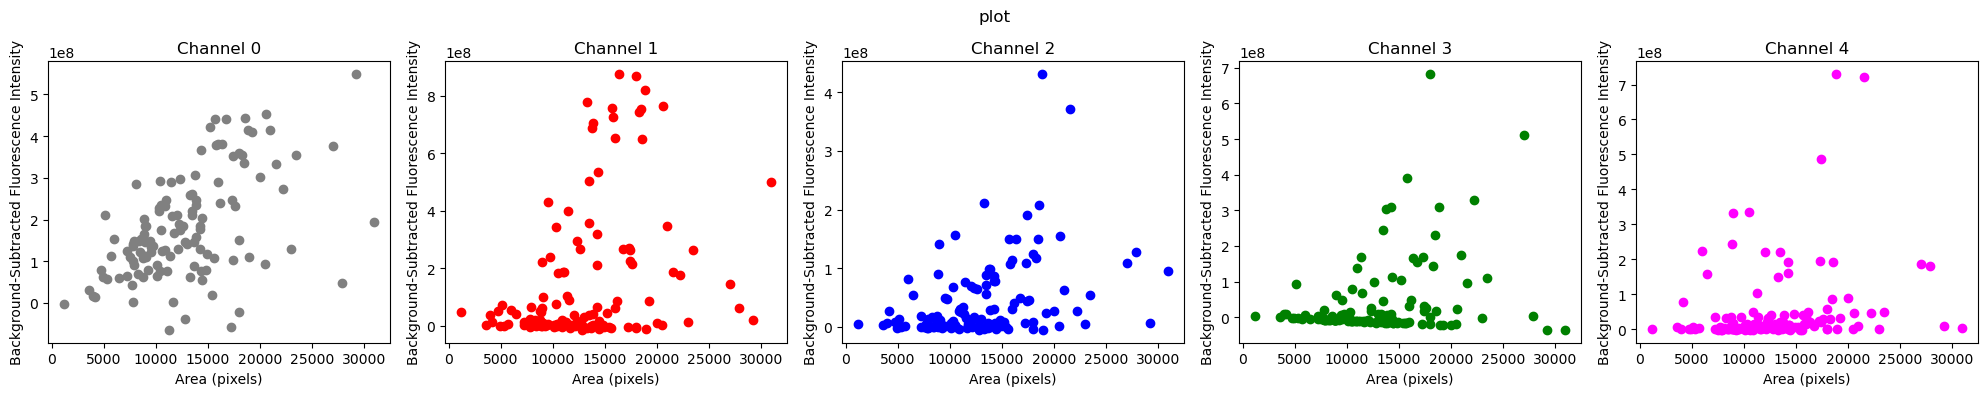

In [9]:
make_plot_vs_area(remove_background(pos_df, bg_df))

In [10]:


binarized_pos = binarize(remove_background(pos_df, bg_df), cutoffs)
binarized_pos

,area_pixels,integrated_intensity_channel_0,integrated_intensity_channel_1,integrated_intensity_channel_2,integrated_intensity_channel_3,integrated_intensity_channel_4,area_pixels_binarized,integrated_intensity_channel_0_binarized,integrated_intensity_channel_1_binarized,integrated_intensity_channel_2_binarized,integrated_intensity_channel_3_binarized,integrated_intensity_channel_4_binarized
label,,,,,,,,,,,,
1,9738.0,1.361009e+08,2.410909e+08,4.687148e+07,1.039553e+07,3.476928e+07,0,0,1,1,0,1
2,10105.0,9.007223e+07,3.320233e+06,5.873233e+06,-1.060613e+07,1.257461e+07,0,0,0,0,0,0
3,21507.0,3.341215e+08,1.883300e+08,3.719249e+08,9.729346e+07,7.224071e+08,0,0,1,1,1,1
4,30981.0,1.931104e+08,5.012018e+08,9.512081e+07,-3.485736e+07,3.088919e+06,0,0,1,1,0,0
5,22979.0,1.301758e+08,1.415762e+07,4.369620e+06,-3.526906e+06,1.102172e+06,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
121,14201.0,1.833544e+08,2.128174e+08,3.030879e+07,-1.052524e+07,2.492817e+05,0,0,1,1,0,0
122,20030.0,3.012376e+08,8.865840e+06,2.662051e+07,-2.144822e+07,9.012118e+07,0,0,0,1,0,1
123,13852.0,2.466197e+08,7.048294e+08,9.894851e+07,2.259493e+06,9.075492e+06,0,0,1,1,0,0


In [11]:
binarized_pos.mean()

area_pixels                                 1.282616e+04
integrated_intensity_channel_0              1.801580e+08
integrated_intensity_channel_1              1.523515e+08
integrated_intensity_channel_2              4.354694e+07
integrated_intensity_channel_3              3.956346e+07
integrated_intensity_channel_4              5.210088e+07
area_pixels_binarized                       0.000000e+00
integrated_intensity_channel_0_binarized    8.000000e-03
integrated_intensity_channel_1_binarized    4.080000e-01
integrated_intensity_channel_2_binarized    4.400000e-01
integrated_intensity_channel_3_binarized    2.400000e-01
integrated_intensity_channel_4_binarized    3.120000e-01
dtype: float64

In [12]:
file_names = []
binarized_means = []

results_folder = os.path.join(image_folder,'binarized_results')
os.makedirs(results_folder, exist_ok=True)

for file in os.listdir(image_folder):
    if file.endswith('.csv'):
        img_df = pd.read_csv(os.path.join(image_folder,file), index_col=0)
        binarized_df = binarize(remove_background(img_df, bg_df), cutoffs)
        binarized_df.to_csv(os.path.join(results_folder,file)+"_binarized.csv") #save results
        binarized_means.append(binarized_df.mean())
        file_names.append(file.split('.')[0])

In [13]:
file_names

['Day11_F2_1',
 'Day10_F2_2',
 'Day9_F2_1_nice_HORMAD1_SYCP3_worm_overlap',
 'Day6_F2_1_higher755',
 'Day1_F3_2',
 'Day8_PGP1_2_four_cells_with_HORMAD1_worms',
 'Day5_F2_1',
 'Day4_F2_2',
 'Day8_F3_2_two_cells_almost_HORMAD1_worms',
 'Day14_F2_2_early_pachytene',
 'iPSC_PGP1_1',
 'Day12_PGP1_2_twopachytene',
 'Day8_PGP1_1_one_cell_with_HORMAD1_worms',
 'Day3_PGP1_2',
 'Day14_F3_1_early_pachytene',
 'Day15_F3_2_maybe_DIPLOTENE',
 'iPSC_F2_2',
 'Day11_F3_2_interesting_maybe_early_pachytene',
 'Day15_PGP1_1_early_pachytene',
 'Day9_F3_2_gorgeous_HORMAD1_SYCP3_overlap',
 'Day6_F3_2',
 'Day3_F2_2',
 'Day9_F3_1_some_HORMAD1_SYCP3_overlap',
 'Day2_F2_1',
 'Day5_PGP1_1',
 'Day13_PGP1_1_maybe_DIPLOTENE_zstack',
 'Day12_F2_2',
 'Day3_F3_2',
 'Day13_F2_2_oneearlypachytene',
 'Day2_F3_1',
 'Day6_F2_2',
 'Day13_F2_1_oneearlypachytene',
 'iPSC_F3_2',
 'Day11_PGP1_2_nice',
 'Day14_PGP1_1',
 'Day9_PGP1_2_three_cells_some_overlap_weak_SYCP3',
 'Day11_F3_1_nice',
 'Day7_PGP1_2',
 'Day11_F3_3_early_pachy

In [14]:
binarized_means

[area_pixels                                 1.533679e+04
 integrated_intensity_channel_0             -8.717384e+06
 integrated_intensity_channel_1              3.389622e+07
 integrated_intensity_channel_2              2.995340e+07
 integrated_intensity_channel_3             -3.537852e+06
 integrated_intensity_channel_4              2.759807e+07
 area_pixels_binarized                       0.000000e+00
 integrated_intensity_channel_0_binarized    0.000000e+00
 integrated_intensity_channel_1_binarized    1.587302e-01
 integrated_intensity_channel_2_binarized    3.571429e-01
 integrated_intensity_channel_3_binarized    7.936508e-02
 integrated_intensity_channel_4_binarized    1.587302e-01
 dtype: float64,
 area_pixels                                 1.789442e+04
 integrated_intensity_channel_0              1.905997e+08
 integrated_intensity_channel_1              1.020659e+08
 integrated_intensity_channel_2              4.433969e+07
 integrated_intensity_channel_3              8.421505e+

In [15]:
summary_df = pd.DataFrame(binarized_means, index=file_names)
summary_df.insert(0, "Cells", [name.split('_')[1] for name in file_names]) #Add the well information based on the file name
summary_df.insert(0, "Day", [name.split('_')[0] for name in file_names]) #Add the well information based on the file name
summary_df.index.name = "File"
summary_df.sort_index(inplace=True)
summary_df.to_csv("2024-05-04_timecourse_stainA_stats.csv")
summary_df
#pd.concat(binarized_means, axis = 1)

,Day,Cells,area_pixels,integrated_intensity_channel_0,integrated_intensity_channel_1,integrated_intensity_channel_2,integrated_intensity_channel_3,integrated_intensity_channel_4,area_pixels_binarized,integrated_intensity_channel_0_binarized,integrated_intensity_channel_1_binarized,integrated_intensity_channel_2_binarized,integrated_intensity_channel_3_binarized,integrated_intensity_channel_4_binarized
File,,,,,,,,,,,,,,
Day10_F2_1_nice_HORMAD1_SYCP3_worm_overlap,Day10,F2,22269.910714,1.477498e+08,1.050698e+08,6.939523e+07,5.617623e+06,7.353939e+07,0.0,0.00000,0.330357,0.553571,0.107143,0.348214
Day10_F2_2,Day10,F2,17894.418919,1.905997e+08,1.020659e+08,4.433969e+07,8.421505e+06,4.023555e+07,0.0,0.02027,0.310811,0.445946,0.155405,0.195946
Day10_F3_1_nice_HORMAD1_SYCP3_worm_overlap,Day10,F3,15234.852632,-6.823180e+06,2.869691e+07,1.617046e+07,-2.743701e+06,1.257970e+07,0.0,0.00000,0.126316,0.226316,0.057895,0.105263
Day10_F3_2_two_cells_nice_HORMAD1_SYCP3_worm_overlap,Day10,F3,14921.591549,-9.792165e+06,5.215645e+07,2.564834e+07,6.335252e+06,2.155272e+07,0.0,0.00000,0.197183,0.316901,0.098592,0.147887
Day10_PGP1_1_nice_HORMAD1_SYCP3_worm_overlap_much_HORMAD1,Day10,PGP1,14761.297872,2.819330e+07,4.765576e+07,1.122312e+07,3.963882e+06,8.334383e+06,0.0,0.00000,0.180851,0.164894,0.117021,0.085106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iPSC_F2_2,iPSC,F2,26019.691358,1.438969e+07,2.353636e+06,9.915879e+04,2.427444e+06,-2.140205e+06,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
iPSC_F3_1,iPSC,F3,21957.164286,2.115476e+07,7.479782e+06,-1.241237e+05,1.596679e+06,-2.992245e+06,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
iPSC_F3_2,iPSC,F3,18528.733333,1.399985e+07,8.721027e+05,-1.523788e+06,-6.731869e+06,-3.093220e+06,0.0,0.00000,0.000000,0.000000,0.000000,0.000000


# plot the results

In [16]:
formatted_df = pd.read_csv("2024-05-04_timecourse_stainA_stats_formatted.csv", index_col=0, keep_default_na=False )
formatted_df

,Day,Cells,DAPI,SYCP3,T2A,HORMAD1,H2AX
File,,,,,,,
Day10_F2_1_nice_HORMAD1_SYCP3_worm_overlap,10,F2,0.00000,0.330357,0.553571,0.107143,0.348214
Day10_F2_2,10,F2,0.02027,0.310811,0.445946,0.155405,0.195946
Day10_F3_1_nice_HORMAD1_SYCP3_worm_overlap,10,F3,0.00000,0.126316,0.226316,0.057895,0.105263
Day10_F3_2_two_cells_nice_HORMAD1_SYCP3_worm_overlap,10,F3,0.00000,0.197183,0.316901,0.098592,0.147887
Day10_PGP1_1_nice_HORMAD1_SYCP3_worm_overlap_much_HORMAD1,10,PGP1,0.00000,0.180851,0.164894,0.117021,0.085106
...,...,...,...,...,...,...,...
iPSC_F2_2,0,F2,0.00000,0.000000,0.000000,0.000000,0.000000
iPSC_F3_1,0,F3,0.00000,0.000000,0.000000,0.000000,0.000000
iPSC_F3_2,0,F3,0.00000,0.000000,0.000000,0.000000,0.000000


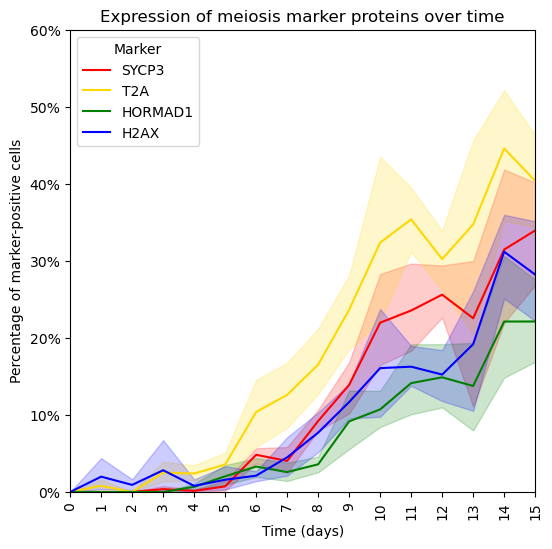

In [17]:
from matplotlib.ticker import FuncFormatter

def percent_format(x, pos):
    return '{:.0f}%'.format(x * 100)

melted_df = pd.melt(formatted_df[["Day","SYCP3","T2A","HORMAD1","H2AX"]], id_vars='Day', var_name='Marker', value_name='Value')
melted_df
plt.figure(figsize=(6, 6))
sns.lineplot(data=melted_df, x='Day', y='Value', hue='Marker', palette = ["red","gold","green","blue"])#palette = ["blue","gold","green","red"])
sns.move_legend(plt.gca(), "upper left")
plt.title('Expression of meiosis marker proteins over time')
#plt.xlabel('Combinations of factors')
plt.xticks(np.arange(0,16), rotation=90)
plt.ylim(0,0.6)
plt.xlim(0,15)
plt.ylabel('Percentage of marker-positive cells')
plt.xlabel('Time (days)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_format))  # Apply custom formatter
#plt.show()
plt.savefig("2024-05-04_timecourse_stainA.png",dpi=256,bbox_inches="tight")
plt.savefig("2024-05-04_timecourse_stainA.svg",bbox_inches="tight")

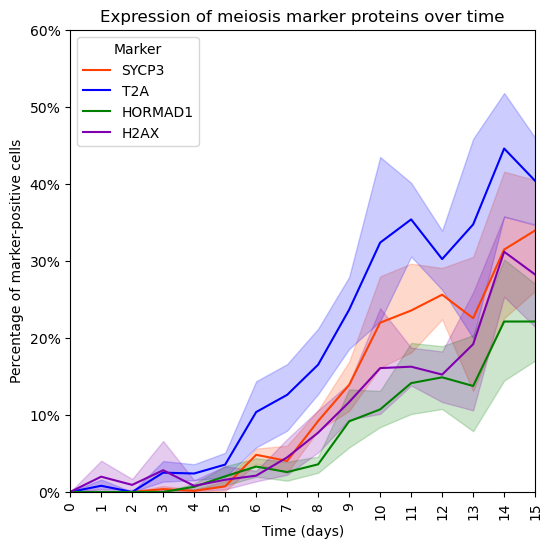

In [18]:
melted_df = pd.melt(formatted_df[["Day","SYCP3","T2A","HORMAD1","H2AX"]], id_vars='Day', var_name='Marker', value_name='Value')
melted_df
plt.figure(figsize=(6, 6))
sns.lineplot(data=melted_df, x='Day', y='Value', hue='Marker', palette = ["#FF4000","blue","green","#8000B0"])#palette = ["blue","gold","green","red"])
sns.move_legend(plt.gca(), "upper left")
plt.title('Expression of meiosis marker proteins over time')
#plt.xlabel('Combinations of factors')
plt.xticks(np.arange(0,16), rotation=90)
plt.ylim(0,0.6)
plt.xlim(0,15)
plt.ylabel('Percentage of marker-positive cells')
plt.xlabel('Time (days)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_format))  # Apply custom formatter
plt.show()

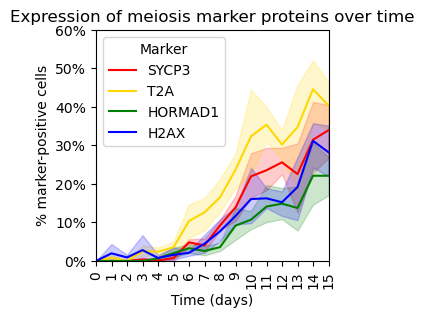

In [21]:
melted_df = pd.melt(formatted_df[["Day","SYCP3","T2A","HORMAD1","H2AX"]], id_vars='Day', var_name='Marker', value_name='Value')
melted_df
plt.figure(figsize=(3, 3))
sns.lineplot(data=melted_df, x='Day', y='Value', hue='Marker', palette = ["red","gold","green","blue"])#palette = ["blue","gold","green","red"])
sns.move_legend(plt.gca(), "upper left")
plt.title('Expression of meiosis marker proteins over time')
#plt.xlabel('Combinations of factors')
plt.xticks(np.arange(0,16), rotation=90)
plt.ylim(0,0.6)
plt.xlim(0,15)
plt.ylabel('% marker-positive cells')
plt.xlabel('Time (days)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_format))  # Apply custom formatter
#plt.show()
plt.savefig("2024-05-04_timecourse_stainA_smaller.png",dpi=256,bbox_inches="tight")
plt.savefig("2024-05-04_timecourse_stainA_smaller.svg",bbox_inches="tight")

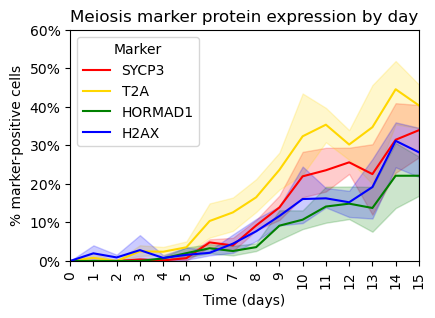

In [25]:
melted_df = pd.melt(formatted_df[["Day","SYCP3","T2A","HORMAD1","H2AX"]], id_vars='Day', var_name='Marker', value_name='Value')
melted_df
plt.figure(figsize=(4.5, 3))
sns.lineplot(data=melted_df, x='Day', y='Value', hue='Marker', palette = ["red","gold","green","blue"])#palette = ["blue","gold","green","red"])
sns.move_legend(plt.gca(), "upper left")
plt.title('Meiosis marker protein expression by day')
#plt.xlabel('Combinations of factors')
plt.xticks(np.arange(0,16), rotation=90)
plt.ylim(0,0.6)
plt.xlim(0,15)
plt.ylabel('% marker-positive cells')
plt.xlabel('Time (days)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_format))  # Apply custom formatter
#plt.show()
plt.savefig("2024-05-24_timecourse_stainA_smaller.png",dpi=256,bbox_inches="tight")
plt.savefig("2024-05-24_timecourse_stainA_smaller.svg",bbox_inches="tight")